In [86]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import io
import fitz
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
%matplotlib inline

## Reading the datasets
### CSVs

In [2]:
# Reading the CSVs
df_train1 = pd.read_csv("train1.csv")
df_train2 = pd.read_csv("train2.csv",sep=';')
df_train1.head()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,EUROPE,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,EUROPE,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019,2,...,EUROPE,12.729453,14.701985,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012,8,...,EUROPE,11.856417,16.122584,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018,12,...,EUROPE,17.111930,20.201604,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a


In [3]:
# Same columns?
print(df_train1.columns == df_train2.columns)
print(df_train1.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
Index(['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
       'pollutant', 'reportingYear', 'MONTH', 'DAY', 'CONTINENT',
       'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp',
       'avg_temp', 'min_temp', 'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID'],
      dtype='object')


### JSONs

In [4]:
# Reading the JSONs
r_first = requests.get('http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first')
df_json1 = pd.DataFrame.from_records(r_first.json())
r_second = requests.get('http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second')
df_json2 = pd.DataFrame.from_records(r_second.json())
r_third = requests.get('http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third')
df_json3 = pd.DataFrame.from_records(r_third.json())
df_json1.head()

,,CITY ID,CONTINENT,City,DAY,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,EPRTRSectorCode,FacilityInspireID,...,countryName,eprtrSectorName,facilityName,max_temp,max_wind_speed,min_temp,min_wind_speed,pollutant,reportingYear,targetRelease
0,47068,4c325d62c064477ef17b4c6e4437e121,EUROPE,Europoort Rotterdam,2,1,4(a),Chemical installations for the production on a...,4,NL.RIVM/000019070.FACILITY,...,Netherlands,Chemical industry,Indorama Ventures Europe BV,13.256816011792559,11.019328717116156,14.696895445152332,20.899761591708206,Carbon dioxide (CO2),2020,AIR
1,32952,f5e609e7095f91cc8ce9ed6d8e774a0d,EUROPE,RION,3,2,3(c),Installations for the production of cement cli...,3,EL.CAED/100075.FACILITY,...,Greece,Mineral industry,TITAN CEMENT S.A. - DREPANO PLANT,4.528859186447803,14.5123950384412,9.219003402711184,23.243402867192145,Nitrogen oxides (NOX),2019,AIR
2,72375,cfab1ba8c67c7c838db98d666f02a132,EUROPE,--,1,12,1(c),Thermal power stations and other combustion in...,1,UK.CAED/BEISOffsh-Cormorant-Alpha.FACILITY,...,United Kingdom,Energy sector,Cormorant Alpha,10.669132597893881,20.26217117993502,14.715465115792192,23.956529199327292,Nitrogen oxides (NOX),2009,AIR
3,40702,95b4e51f7b662598134e1eb956407c74,EUROPE,DRIZZONA,17,1,7(a),Installations for the intensive rearing of pou...,7,IT.CAED/260342003.FACILITY,...,Italy,Intensive livestock production and aquaculture,SOCIETA' AGRICOLA SPARAVALLE DI FERRARI GIUSEP...,7.095681595088376,18.28354666681811,13.582024001859644,26.69626609353847,Methane (CH4),2014,AIR
4,29884,f4433be3b1bfaeeb0633eb65d04b1325,EUROPE,Lünen,6,0,5(a),Installations for the recovery or disposal of ...,5,https://registry.gdi-de.org/id/de.nw.inspire.p...,...,Germany,Waste and wastewater management,Biomassekraftwerk Lünen GmbH,9.886774464050356,13.75940846376134,14.00622637509683,24.768932565830674,Carbon dioxide (CO2),2015,AIR


In [5]:
df_json1["reportingYear"] = pd.to_numeric(df_json1["reportingYear"])
df_json1["MONTH"] = pd.to_numeric(df_json1["MONTH"])
df_json1["DAY"] = pd.to_numeric(df_json1["DAY"])
df_json1["max_wind_speed"] = pd.to_numeric(df_json1["max_wind_speed"])
df_json1["avg_wind_speed"] = pd.to_numeric(df_json1["avg_wind_speed"])
df_json1["min_wind_speed"] = pd.to_numeric(df_json1["min_wind_speed"])
df_json1["max_temp"] = pd.to_numeric(df_json1["max_temp"])
df_json1["avg_temp"] = pd.to_numeric(df_json1["avg_temp"])
df_json1["min_temp"] = pd.to_numeric(df_json1["min_temp"])
df_json1["DAY WITH FOGS"] = pd.to_numeric(df_json1["DAY WITH FOGS"])

df_json2["reportingYear"] = pd.to_numeric(df_json2["reportingYear"])
df_json2["MONTH"] = pd.to_numeric(df_json2["MONTH"])
df_json2["DAY"] = pd.to_numeric(df_json2["DAY"])
df_json2["max_wind_speed"] = pd.to_numeric(df_json2["max_wind_speed"])
df_json2["avg_wind_speed"] = pd.to_numeric(df_json2["avg_wind_speed"])
df_json2["min_wind_speed"] = pd.to_numeric(df_json2["min_wind_speed"])
df_json2["max_temp"] = pd.to_numeric(df_json2["max_temp"])
df_json2["avg_temp"] = pd.to_numeric(df_json2["avg_temp"])
df_json2["min_temp"] = pd.to_numeric(df_json2["min_temp"])
df_json2["DAY WITH FOGS"] = pd.to_numeric(df_json2["DAY WITH FOGS"])

df_json3["reportingYear"] = pd.to_numeric(df_json3["reportingYear"])
df_json3["MONTH"] = pd.to_numeric(df_json3["MONTH"])
df_json3["DAY"] = pd.to_numeric(df_json3["DAY"])
df_json3["max_wind_speed"] = pd.to_numeric(df_json3["max_wind_speed"])
df_json3["avg_wind_speed"] = pd.to_numeric(df_json3["avg_wind_speed"])
df_json3["min_wind_speed"] = pd.to_numeric(df_json3["min_wind_speed"])
df_json3["max_temp"] = pd.to_numeric(df_json3["max_temp"])
df_json3["avg_temp"] = pd.to_numeric(df_json3["avg_temp"])
df_json3["min_temp"] = pd.to_numeric(df_json3["min_temp"])
df_json3["DAY WITH FOGS"] = pd.to_numeric(df_json3["DAY WITH FOGS"])

In [6]:
# Same columns?
print(df_json1.columns == df_json2.columns)
print(df_json1.columns == df_json3.columns)
print(df_json1.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
Index(['', 'CITY ID', 'CONTINENT', 'City', 'DAY', 'DAY WITH FOGS',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'EPRTRSectorCode', 'FacilityInspireID', 'MONTH', 'REPORTER NAME',
       'avg_temp', 'avg_wind_speed', 'countryName', 'eprtrSectorName',
       'facilityName', 'max_temp', 'max_wind_speed', 'min_temp',
       'min_wind_speed', 'pollutant', 'reportingYear', 'targetRelease'],
      dtype='object')


### Automated PDFs

In [7]:
pdf_directory = './train6'
pdf_jsons = []
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        doc = fitz.open(os.path.join(pdf_directory, filename))
        text = ''
        for page in doc:
            # do something with 'page'
            text += page.get_text('text')
        buf = io.StringIO(text)
        buf.readline() # REPORT CONTAMINACIÓN
        buf.readline() # nº:
        id_pdf = buf.readline()
        buf.readline() # FACILITY NAME:
        facilityName = buf.readline()[:-1]
        trash_number = buf.readline()[:-1] # id_pdf+1
        if trash_number.isdigit():
            buf.readline() # FacilityInspireID:
        FacilityInspireID = buf.readline()[:-1]
        buf.readline() # COUNTRY:
        countryName = buf.readline()[:-1]
        buf.readline() # CONTINENT:
        CONTINENT = buf.readline()[:-1]
        buf.readline() # CITY:
        City = buf.readline()[:-1]
        buf.readline() # EPRTRSectorCode:
        EPRTRSectorCode = buf.readline()[:-1]
        buf.readline() # eprtrSectorName:
        eprtrSectorName = buf.readline()[:-1]
        MainActivityCode = buf.readline()[17:-1] # MainActivityCode:
        buf.readline() # targetRealase:
        targetRelease = buf.readline()[:-1]
        buf.readline() # pollutant:
        pollutant = buf.readline()[:-1]
        buf.readline() # emissions:
        emissions = buf.readline()[:-1]
        buf.readline() # DAY:
        DAY = buf.readline()[:-1]
        buf.readline() # MONTH:
        MONTH = buf.readline()[:-1].split(' ')[0]
        reportingYear = buf.readline()[:-1] # YEAR:
        buf.readline() # METEOROLOGICAL CONDITIONS
        met_cond = ''
        line = buf.readline()[:-1]
        while line != 'DAYS FOG:':
            met_cond = met_cond + ' ' + line
            line = buf.readline()[:-1]
        met_cond_words = met_cond.split(' ')
        max_wind_speed = met_cond_words[2]
        min_wind_speed = met_cond_words[4]
        avg_wind_speed = met_cond_words[6]
        max_temp = met_cond_words[8]
        min_temp = met_cond_words[10]
        avg_temp = met_cond_words[12]
        DAYS_WITH_FOGS = buf.readline()[:-1]
        REPORTER_NAME = buf.readline()[:-1][14:] # REPORTER NAME
        buf.readline() # CITY_ID:
        CITY_ID = buf.readline()[:-1]
        pdf_json = {
            'id_pdf': int(id_pdf),
            'facilityName': facilityName,
            'FacilityInspireID': FacilityInspireID,
            'countryName': countryName,
            'CONTINENT': CONTINENT,
            'City': City,
            'EPRTRSectorCode': int(EPRTRSectorCode),
            'eprtrSectorName': eprtrSectorName,
            'MainActivityCode': MainActivityCode,
            'targetRelease': targetRelease,
            'pollutant': pollutant,
            'emissions': None, #emissions.replace(',','.'),
            'DAY': DAY,
            'MONTH': MONTH,
            'reportingYear': reportingYear,
            'max_wind_speed': None, #max_wind_speed.replace(',','.'),
            'min_wind_speed': None, #min_wind_speed.replace(',','.'),
            'avg_wind_speed': None, #avg_wind_speed.replace(',','.'),
            'max_temp': None, #max_temp.replace(',','.'),
            'min_temp': None, #min_temp.replace(',','.'),
            'avg_temp': None, #avg_temp.replace(',','.'),
            'DAYS WITH FOGS': DAYS_WITH_FOGS,
            'REPORTER NAME': REPORTER_NAME,
            'CITY ID': CITY_ID
        }
        pdf_jsons.append(pdf_json)

In [8]:
df_pdfs = pd.DataFrame.from_records(pdf_jsons)
df_pdfs.head()

,id_pdf,facilityName,FacilityInspireID,countryName,CONTINENT,City,EPRTRSectorCode,eprtrSectorName,MainActivityCode,targetRelease,...,reportingYear,max_wind_speed,min_wind_speed,avg_wind_speed,max_temp,min_temp,avg_temp,DAYS WITH FOGS,REPORTER NAME,CITY ID
0,81536,"Greenoakhill Landfill Site, Glasgow",UK.SEPA/200000110.Facility,United Kingdom,EUROPE,Mount Vernon,5,Waste and wastewater management,5(d),AIR,...,2019,None,None,None,None,None,None,7,Jodi Holden,5a9cc0e1663ad226675e57387c5e24e6
1,81522,"Auchencarroch Landfill, Jamestown",UK.SEPA/200000083.Facility,United Kingdom,EUROPE,Alexandria,5,Waste and wastewater management,5(d),AIR,...,2019,None,None,None,None,None,None,12,Tracy Powell,a6bc8f85a33112c5beea4d357caad4cd
2,81523,"Garlaff Landfill Site, Cumnock",UK.SEPA/200000084.Facility,United Kingdom,EUROPE,Cumnock,5,Waste and wastewater management,5(d),AIR,...,2019,None,None,None,None,None,None,11,Rebecca Brooks,b6ca640b7121ae2bf206ea088f6a4618
3,81537,"Easter Langlee Landfill Site, Galashiels",UK.SEPA/200000113.Facility,United Kingdom,EUROPE,Galashiels,5,Waste and wastewater management,5(d),AIR,...,2019,None,None,None,None,None,None,7,Ashley Villa,ff6f902129dcd065ed5a34da955999a7
4,81521,Auchenlosh Landfill Site,UK.SEPA/200000082.Facility,United Kingdom,EUROPE,Dalbeattie,5,Waste and wastewater management,5(d),AIR,...,2019,None,None,None,None,None,None,2,Brian Sims,d52bec466f0edb76a6fc14c109598ba2


In [9]:
df_pdfs.columns

Index(['id_pdf', 'facilityName', 'FacilityInspireID', 'countryName',
       'CONTINENT', 'City', 'EPRTRSectorCode', 'eprtrSectorName',
       'MainActivityCode', 'targetRelease', 'pollutant', 'emissions', 'DAY',
       'MONTH', 'reportingYear', 'max_wind_speed', 'min_wind_speed',
       'avg_wind_speed', 'max_temp', 'min_temp', 'avg_temp', 'DAYS WITH FOGS',
       'REPORTER NAME', 'CITY ID'],
      dtype='object')

### CSV output

In [10]:
# Reading the CSVs
df_test = pd.read_csv("test_x.csv")
df_test.head()

,test_index,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,...,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
0,0,Poland,3,Mineral industry,3(a),Underground mining and related operations,PL.MŚ/000002357.FACILITY,Polska Grupa Górnicza sp. z o.o. Oddział KWK R...,Rydułtowy,AIR,...,EUROPE,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1,Brittany Buck,826b1de9dad293ae3e4f9cbaf6cf3420
1,1,Luxembourg,5,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,LU.CAED/000012000.FACILITY,Sidec,Diekirch,AIR,...,EUROPE,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0,Lauren Fisher,ed30a6667b40ba0a66198b3173e7353f
2,2,Netherlands,1,Energy sector,1(c),Thermal power stations and other combustion in...,NL.EEA/212857.FACILITY,Nuon Power Generation BV (Eemshaven),Eemshaven,AIR,...,EUROPE,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2,Linda Thompson,78e1082c3cfef3bdf3554da8d6afcc34
3,3,Sweden,5,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,SE.CAED/10013901.Facility,HÖGBYTORPS AVFALLSANLÄGGNING,BRO,AIR,...,EUROPE,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2,Bethany Mcmillan,27f959641950d381869d746d7d0e7d4e
4,4,Portugal,1,Energy sector,1(c),Thermal power stations and other combustion in...,PT.EEA/133926.FACILITY,SPCG - Sociedade Portuguesa de Co-Geração Eléc...,SETÚBAL,AIR,...,EUROPE,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2,Sarah Hoffman,1cb71655d9e0bd5cedb2320bf5fdd8f7


In [11]:
df_test.isnull().sum()

test_index                      0
countryName                     0
EPRTRSectorCode                 0
eprtrSectorName                 0
EPRTRAnnexIMainActivityCode     0
EPRTRAnnexIMainActivityLabel    0
FacilityInspireID               0
facilityName                    0
City                            0
targetRelease                   0
reportingYear                   0
MONTH                           0
DAY                             0
CONTINENT                       0
max_wind_speed                  0
avg_wind_speed                  0
min_wind_speed                  0
max_temp                        0
avg_temp                        0
min_temp                        0
DAY WITH FOGS                   0
REPORTER NAME                   0
CITY ID                         0
dtype: int64

In [12]:
df_test.columns

Index(['test_index', 'countryName', 'EPRTRSectorCode', 'eprtrSectorName',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
       'reportingYear', 'MONTH', 'DAY', 'CONTINENT', 'max_wind_speed',
       'avg_wind_speed', 'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp',
       'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID'],
      dtype='object')

In [13]:
print(f'Len df_train1: {len(df_train1)}')
print(f'Len df_train2: {len(df_train2)}')
print(f'Len df_json1: {len(df_json1)}')
print(f'Len df_json2: {len(df_json2)}')
print(f'Len df_json3: {len(df_json3)}')
print(f'Len df_pdfs: {len(df_pdfs)}')
print(f'Len df_test: {len(df_test)}')

Len df_train1: 18563
Len df_train2: 18564
Len df_json1: 9500
Len df_json2: 9500
Len df_json3: 9501
Len df_pdfs: 82
Len df_test: 24480


## Univariate and Bivariate Analysis
### CSVs

In [14]:
# Checking the missing values
df_train1.isnull().sum()

countryName                     0
eprtrSectorName                 0
EPRTRAnnexIMainActivityLabel    0
FacilityInspireID               0
facilityName                    0
City                            0
targetRelease                   0
pollutant                       0
reportingYear                   0
MONTH                           0
DAY                             0
CONTINENT                       0
max_wind_speed                  0
avg_wind_speed                  0
min_wind_speed                  0
max_temp                        0
avg_temp                        0
min_temp                        0
DAY WITH FOGS                   0
REPORTER NAME                   0
CITY ID                         0
dtype: int64

In [15]:
df_train2.isnull().sum()

countryName                     0
eprtrSectorName                 0
EPRTRAnnexIMainActivityLabel    0
FacilityInspireID               0
facilityName                    0
City                            0
targetRelease                   0
pollutant                       0
reportingYear                   0
MONTH                           0
DAY                             0
CONTINENT                       0
max_wind_speed                  0
avg_wind_speed                  0
min_wind_speed                  0
max_temp                        0
avg_temp                        0
min_temp                        0
DAY WITH FOGS                   0
REPORTER NAME                   0
CITY ID                         0
dtype: int64

In [16]:
df_train1.describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000,18563.000000
mean,2012.975704,6.503313,14.464418,15.510211,18.014757,22.508414,9.452347,10.451482,13.446192,2.207025
std,3.854872,3.465847,8.106617,3.082789,2.318713,3.057952,5.225111,5.089731,5.224863,3.754474
min,2007.000000,1.000000,1.000000,8.080201,14.000287,15.059535,-3.141464,-0.199176,0.995273,0.000000
25%,2010.000000,3.000000,7.000000,13.304456,15.996399,20.346224,5.879811,7.152314,9.900043,0.000000
50%,2013.000000,7.000000,14.000000,15.500360,17.996762,22.535807,9.719526,10.727545,13.719227,1.000000
75%,2016.000000,10.000000,22.000000,17.702003,20.026096,24.668311,13.284980,14.174231,17.264452,2.000000
max,2020.000000,12.000000,28.000000,22.991382,21.999973,29.904342,20.855885,19.998710,24.855425,19.000000


In [17]:
df_train2.describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000,18564.000000
mean,2012.927979,6.470750,14.616246,15.510827,18.012436,22.538703,9.452497,10.431640,13.415838,2.249407
std,3.857427,3.468229,8.149508,3.057618,2.308151,3.071878,5.239448,5.098382,5.225626,3.796891
min,2007.000000,1.000000,1.000000,8.062689,14.000399,15.055647,-3.141464,-0.199176,0.894827,0.000000
25%,2010.000000,3.000000,8.000000,13.325466,16.022821,20.384529,5.833546,7.165987,9.838050,0.000000
50%,2013.000000,7.000000,15.000000,15.508749,18.017308,22.576266,9.738077,10.737833,13.728526,1.000000
75%,2016.000000,9.000000,22.000000,17.714364,19.996546,24.762390,13.287710,14.151906,17.194959,2.000000
max,2020.000000,12.000000,28.000000,22.991382,21.999875,29.914367,20.847544,19.999403,24.812789,19.000000


df_train1 and df_train2 seem similar enough to be merged

In [18]:
df_train = pd.concat([df_train1,df_train2])
df_train.describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000
mean,2012.951841,6.487031,14.540335,15.510519,18.013596,22.523559,9.452422,10.441560,13.431015,2.228217
std,3.856172,3.467030,8.128336,3.070188,2.313407,3.064919,5.232214,5.094000,5.225196,3.775751
min,2007.000000,1.000000,1.000000,8.062689,14.000287,15.055647,-3.141464,-0.199176,0.894827,0.000000
25%,2010.000000,3.000000,8.000000,13.315477,16.007158,20.361339,5.855159,7.158428,9.866841,0.000000
50%,2013.000000,7.000000,15.000000,15.503568,18.006838,22.553985,9.734382,10.733914,13.723792,1.000000
75%,2016.000000,9.000000,22.000000,17.708038,20.013530,24.713992,13.287165,14.162492,17.235091,2.000000
max,2020.000000,12.000000,28.000000,22.991382,21.999973,29.914367,20.855885,19.999403,24.855425,19.000000


In [19]:
df_train.countryName.describe()

count       37127
unique         32
top       Germany
freq         5055
Name: countryName, dtype: object

In [20]:
df_train.eprtrSectorName.describe()

count             37127
unique                9
top       Energy sector
freq              13914
Name: eprtrSectorName, dtype: object

In [21]:
df_train.EPRTRAnnexIMainActivityLabel.describe()

count                                                 37127
unique                                                   70
top       Thermal power stations and other combustion in...
freq                                                  12149
Name: EPRTRAnnexIMainActivityLabel, dtype: object

In [22]:
df_train.FacilityInspireID.describe()

count                                                 37127
unique                                                 6306
top       https://data.ied_registry.omgeving.vlaanderen....
freq                                                     32
Name: FacilityInspireID, dtype: object

In [23]:
df_train.City.describe()

count     37127
unique     4514
top          --
freq       1116
Name: City, dtype: object

In [24]:
df_train.targetRelease.describe()

count     37127
unique        1
top         AIR
freq      37127
Name: targetRelease, dtype: object

In [25]:
df_train.CONTINENT.describe()

count      37127
unique         1
top       EUROPE
freq       37127
Name: CONTINENT, dtype: object

In [26]:
df_train['REPORTER NAME'].describe()

count             37127
unique            24686
top       Michael Brown
freq                 17
Name: REPORTER NAME, dtype: object

In [27]:
df_train['CITY ID'].describe()

count                                37127
unique                                4514
top       cfab1ba8c67c7c838db98d666f02a132
freq                                  1116
Name: CITY ID, dtype: object

In [28]:
df_train['outcome'] = df_train['pollutant'].replace(['Nitrogen oxides (NOX)'],0).replace(['Carbon dioxide (CO2)'],1).replace(['Methane (CH4)'],2)
df_train.columns

Index(['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
       'pollutant', 'reportingYear', 'MONTH', 'DAY', 'CONTINENT',
       'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp',
       'avg_temp', 'min_temp', 'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID',
       'outcome'],
      dtype='object')

In [29]:
df_train.outcome.unique()

array([1, 0, 2], dtype=int64)

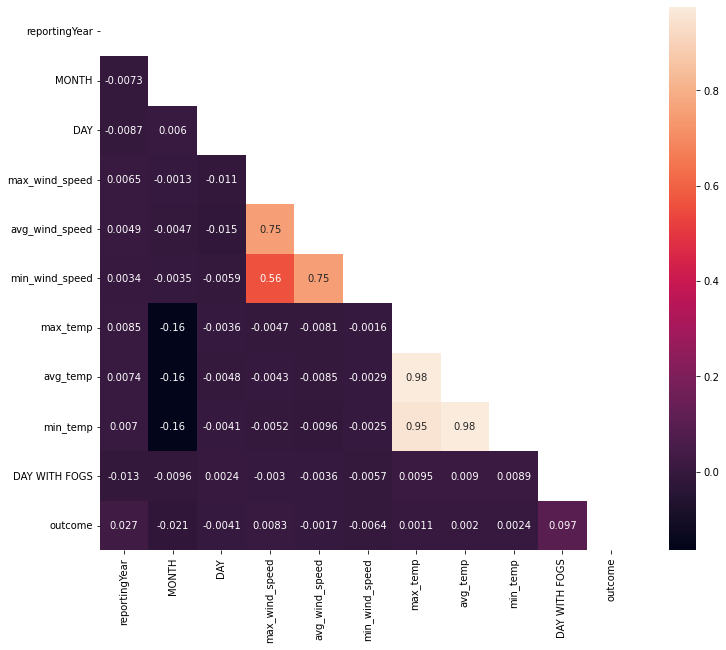

In [30]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor_pearson = df_train.corr(method ='pearson')
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(cor_pearson)
sns.heatmap(cor_pearson, annot=True, mask=matrix)
plt.show()

In [31]:
df_exp = pd.get_dummies(df_train,prefix=['countryName'], columns = ['countryName'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['eprtrSectorName'], columns = ['eprtrSectorName'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['EPRTRAnnexIMainActivityLabel'], columns = ['EPRTRAnnexIMainActivityLabel'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['FacilityInspireID'], columns = ['FacilityInspireID'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['facilityName'], columns = ['facilityName'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['City'], columns = ['City'], drop_first=True)
df_exp = pd.get_dummies(df_exp,prefix=['targetRelease'], columns = ['targetRelease'], drop_first=True)
#df_exp = pd.get_dummies(df_train,prefix=['REPORTER_NAME'], columns = ['REPORTER NAME'], drop_first=True) Deleted because generate lots of noise
len(df_exp.columns)

17644

In [32]:
len(df_exp)

37127

In [33]:
df_corr = df_exp
outcome_corr = df_corr.corrwith(df_corr['outcome']).abs()

In [34]:
df_corr = pd.DataFrame({'column_name':outcome_corr.index, 'corr_value':outcome_corr.values})

In [72]:
df_corr = df_corr.sort_values(by='corr_value',ascending=False)
top_corr_variables_train = df_corr[1:100].column_name.to_list()
print(top_corr_variables_train[:100])

['EPRTRAnnexIMainActivityLabel_Landfills (excluding landfills of inert waste and landfills, which were definitely closed before 16.7.2001 or for which the after-care phase required by the competent authorities according to Article 13 of Council Directive 1999/31/EC of 26 April 1999 on the landfill of waste has expired)', 'eprtrSectorName_Waste and wastewater management', 'eprtrSectorName_Intensive livestock production and aquaculture', 'eprtrSectorName_Energy sector', 'EPRTRAnnexIMainActivityLabel_Thermal power stations and other combustion installations', 'EPRTRAnnexIMainActivityLabel_Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)', 'eprtrSectorName_Mineral industry', 'EPRTRAnnexIMainActivityLabel_Installations for the manufacture of glass, including glass fibre', 'eprtrSectorName_Paper and wood production and processing', 'EPRTRAnnexIMainActivityLabel_Installations for the disposal of non-hazardous waste', 'EPRTRAnnexIMainActivityLa

In [36]:
X = df_exp.filter(top_corr_variables_train,axis=1)
cols = []
count = 1
for column in X.columns:
    cols.append(f'Col_{count}')
    count+=1
X.columns = cols
X.head()

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,...,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ML Experiments

As for the limited time of the competition and the high amount of variables, LightGBM and Catboost are suitable. As for my hardware specs, LightGBM has been chosen.

In [71]:
# get X, y
y = df_exp.outcome
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

f1_macro: 0.648 (0.007)


Now that we have roughly found the most important variables, lets see if the other datasets are suitable to merge as well
### JSONs

In [38]:
df_json1.isnull().sum()

                                0
CITY ID                         0
CONTINENT                       0
City                            0
DAY                             0
DAY WITH FOGS                   0
EPRTRAnnexIMainActivityCode     0
EPRTRAnnexIMainActivityLabel    0
EPRTRSectorCode                 0
FacilityInspireID               0
MONTH                           0
REPORTER NAME                   0
avg_temp                        0
avg_wind_speed                  0
countryName                     0
eprtrSectorName                 0
facilityName                    0
max_temp                        0
max_wind_speed                  0
min_temp                        0
min_wind_speed                  0
pollutant                       0
reportingYear                   0
targetRelease                   0
dtype: int64

In [39]:
df_json2.isnull().sum()

                                0
CITY ID                         0
CONTINENT                       0
City                            0
DAY                             0
DAY WITH FOGS                   0
EPRTRAnnexIMainActivityCode     0
EPRTRAnnexIMainActivityLabel    0
EPRTRSectorCode                 0
FacilityInspireID               0
MONTH                           0
REPORTER NAME                   0
avg_temp                        0
avg_wind_speed                  0
countryName                     0
eprtrSectorName                 0
facilityName                    0
max_temp                        0
max_wind_speed                  0
min_temp                        0
min_wind_speed                  0
pollutant                       0
reportingYear                   0
targetRelease                   0
dtype: int64

In [40]:
df_json3.isnull().sum()

                                0
CITY ID                         0
CONTINENT                       0
City                            0
DAY                             0
DAY WITH FOGS                   0
EPRTRAnnexIMainActivityCode     0
EPRTRAnnexIMainActivityLabel    0
EPRTRSectorCode                 0
FacilityInspireID               0
MONTH                           0
REPORTER NAME                   0
avg_temp                        0
avg_wind_speed                  0
countryName                     0
eprtrSectorName                 0
facilityName                    0
max_temp                        0
max_wind_speed                  0
min_temp                        0
min_wind_speed                  0
pollutant                       0
reportingYear                   0
targetRelease                   0
dtype: int64

In [41]:
df_json1.filter(['reportingYear','MONTH','DAY','max_wind_speed','avg_wind_speed','min_wind_speed','max_temp','avg_temp','min_temp','DAY WITH FOGS']).describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000
mean,2012.866947,6.515895,14.512211,15.505081,17.996647,22.474114,9.533554,10.500084,13.499214,2.233895
std,3.846401,3.417729,7.995614,3.046861,2.302477,3.063607,5.238468,5.112990,5.245470,3.780540
min,2007.000000,1.000000,1.000000,8.011958,14.000376,15.032589,-3.033178,-0.198657,1.003606,0.000000
25%,2010.000000,4.000000,8.000000,13.351367,16.002478,20.261457,5.970120,7.260976,9.966744,0.000000
50%,2013.000000,7.000000,14.000000,15.473085,18.001011,22.478699,9.812241,10.735480,13.724911,1.000000
75%,2016.000000,9.000000,21.000000,17.727081,19.976819,24.666446,13.376778,14.282189,17.424320,2.000000
max,2020.000000,12.000000,28.000000,22.945514,21.999570,29.925567,20.819540,19.998479,24.840671,19.000000


In [42]:
df_json2.filter(['reportingYear','MONTH','DAY','max_wind_speed','avg_wind_speed','min_wind_speed','max_temp','avg_temp','min_temp','DAY WITH FOGS']).describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,9500.000000,9500.00000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000,9500.000000
mean,2012.935263,6.52000,14.398000,15.522277,18.011941,22.530332,9.443865,10.461075,13.483147,2.206947
std,3.849949,3.43761,8.111291,3.084357,2.308848,3.030115,5.201291,5.086957,5.214447,3.735732
min,2007.000000,1.00000,1.000000,8.060774,14.002063,15.101682,-3.075563,-0.197947,0.895952,0.000000
25%,2010.000000,4.00000,7.000000,13.310353,16.001228,20.374858,5.939818,7.208914,9.950253,0.000000
50%,2013.000000,7.00000,14.000000,15.477024,18.040871,22.541236,9.615715,10.629759,13.654195,1.000000
75%,2016.000000,10.00000,22.000000,17.726923,20.008316,24.735358,13.225062,14.257122,17.323824,2.000000
max,2020.000000,12.00000,28.000000,22.947671,21.999891,29.933603,20.938266,19.998588,24.902108,19.000000


In [43]:
df_json3.filter(['reportingYear','MONTH','DAY','max_wind_speed','avg_wind_speed','min_wind_speed','max_temp','avg_temp','min_temp','DAY WITH FOGS']).describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,9501.00000,9501.000000,9501.000000,9501.000000,9501.000000,9501.000000,9501.000000,9501.000000,9501.000000,9501.000000
mean,2012.93727,6.445532,14.550995,15.541768,18.043861,22.548810,9.400468,10.408989,13.392290,2.273866
std,3.85463,3.433505,8.063162,3.059404,2.310550,3.066673,5.147821,5.016413,5.152180,3.829160
min,2007.00000,1.000000,1.000000,8.137407,14.000100,15.163679,-2.939165,-0.198574,1.110996,0.000000
25%,2010.00000,3.000000,8.000000,13.338310,16.058827,20.363842,5.851200,7.190151,9.849804,0.000000
50%,2013.00000,6.000000,15.000000,15.576464,18.074406,22.556224,9.570502,10.564345,13.578860,1.000000
75%,2016.00000,9.000000,21.000000,17.746535,20.034921,24.740729,13.194710,14.174931,17.231056,2.000000
max,2020.00000,12.000000,28.000000,22.941042,21.999919,29.906586,20.855570,19.998645,24.884842,19.000000


df_json1, df_json2 and df_json3 seem similar enough to be merged as well

In [44]:
df_json = pd.concat([df_json1,df_json2,df_json3])
df_json.filter(['reportingYear','MONTH','DAY','max_wind_speed','avg_wind_speed','min_wind_speed','max_temp','avg_temp','min_temp','DAY WITH FOGS']).describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000,28501.000000
mean,2012.913161,6.493807,14.487071,15.523043,18.017484,22.517753,9.459294,10.456714,13.458214,2.238237
std,3.850332,3.429675,8.056808,3.063509,2.307298,3.053568,5.196105,5.072242,5.204205,3.781972
min,2007.000000,1.000000,1.000000,8.011958,14.000100,15.032589,-3.075563,-0.198657,0.895952,0.000000
25%,2010.000000,4.000000,8.000000,13.334361,16.020135,20.325445,5.916845,7.219282,9.927093,0.000000
50%,2013.000000,7.000000,14.000000,15.512050,18.036467,22.523903,9.659857,10.661131,13.651201,1.000000
75%,2016.000000,9.000000,21.000000,17.734876,20.010966,24.717001,13.272888,14.235023,17.319572,2.000000
max,2020.000000,12.000000,28.000000,22.947671,21.999919,29.933603,20.938266,19.998645,24.902108,19.000000


In [45]:
df_train.filter(['reportingYear','MONTH','DAY','max_wind_speed','avg_wind_speed','min_wind_speed','max_temp','avg_temp','min_temp','DAY WITH FOGS']).describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000
mean,2012.951841,6.487031,14.540335,15.510519,18.013596,22.523559,9.452422,10.441560,13.431015,2.228217
std,3.856172,3.467030,8.128336,3.070188,2.313407,3.064919,5.232214,5.094000,5.225196,3.775751
min,2007.000000,1.000000,1.000000,8.062689,14.000287,15.055647,-3.141464,-0.199176,0.894827,0.000000
25%,2010.000000,3.000000,8.000000,13.315477,16.007158,20.361339,5.855159,7.158428,9.866841,0.000000
50%,2013.000000,7.000000,15.000000,15.503568,18.006838,22.553985,9.734382,10.733914,13.723792,1.000000
75%,2016.000000,9.000000,22.000000,17.708038,20.013530,24.713992,13.287165,14.162492,17.235091,2.000000
max,2020.000000,12.000000,28.000000,22.991382,21.999973,29.914367,20.855885,19.999403,24.855425,19.000000


df_train and df_json seem similar as well. Merged

In [46]:
df_train_json = pd.concat([df_train,df_json])
df_train_json = df_train_json.fillna(0)

Lets check what the corr top ranking looks like now and see how the model behaves with this new data

In [47]:
df_exp_2 = pd.get_dummies(df_train_json,prefix=['countryName'], columns = ['countryName'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['eprtrSectorName'], columns = ['eprtrSectorName'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['EPRTRAnnexIMainActivityLabel'], columns = ['EPRTRAnnexIMainActivityLabel'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['FacilityInspireID'], columns = ['FacilityInspireID'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['facilityName'], columns = ['facilityName'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['City'], columns = ['City'], drop_first=True)
df_exp_2 = pd.get_dummies(df_exp_2,prefix=['targetRelease'], columns = ['targetRelease'], drop_first=True)
#df_exp = pd.get_dummies(df_train,prefix=['REPORTER_NAME'], columns = ['REPORTER NAME'], drop_first=True) Deleted because generate lots of noise
len(df_exp_2.columns)

20375

In [48]:
df_corr_2 = df_exp_2
outcome_corr_2 = df_corr_2.corrwith(df_corr_2['outcome']).abs()

In [49]:
df_corr_2 = pd.DataFrame({'column_name':outcome_corr_2.index, 'corr_value':outcome_corr_2.values})

In [85]:
df_corr[1:20]

,column_name,corr_value
106,EPRTRAnnexIMainActivityLabel_Landfills (exclud...,0.586435
49,eprtrSectorName_Waste and wastewater management,0.502344
44,eprtrSectorName_Intensive livestock production...,0.262946
43,eprtrSectorName_Energy sector,0.230447
112,EPRTRAnnexIMainActivityLabel_Thermal power sta...,0.213814
85,EPRTRAnnexIMainActivityLabel_Installations for...,0.199919
45,eprtrSectorName_Mineral industry,0.180392
91,EPRTRAnnexIMainActivityLabel_Installations for...,0.172298
47,eprtrSectorName_Paper and wood production and ...,0.133164
82,EPRTRAnnexIMainActivityLabel_Installations for...,0.127382


In [73]:
df_corr_2 = df_corr_2.sort_values(by='corr_value',ascending=False)
top_corr_variables_train_json = df_corr_2[1:100].column_name.to_list()
print(top_corr_variables_train_json[:100])
print(top_corr_variables_train[:9] == top_corr_variables_train_json[:9])

['EPRTRAnnexIMainActivityLabel_Landfills (excluding landfills of inert waste and landfills, which were definitely closed before 16.7.2001 or for which the after-care phase required by the competent authorities according to Article 13 of Council Directive 1999/31/EC of 26 April 1999 on the landfill of waste has expired)', 'eprtrSectorName_Waste and wastewater management', 'eprtrSectorName_Intensive livestock production and aquaculture', 'eprtrSectorName_Energy sector', 'EPRTRAnnexIMainActivityLabel_Thermal power stations and other combustion installations', 'EPRTRAnnexIMainActivityLabel_Installations for the intensive rearing of pigs with 2,000 places for production pigs (over 30 kg)', 'eprtrSectorName_Mineral industry', 'EPRTRAnnexIMainActivityLabel_Installations for the manufacture of glass, including glass fibre', 'eprtrSectorName_Paper and wood production and processing', 'EPRTRAnnexIMainActivityLabel_Installations for the intensive rearing of poultry or pigs. Note to reporters, use

In [51]:
X_2 = df_exp_2.filter(top_corr_variables_train_json,axis=1)
cols = []
count = 1
for column in X_2.columns:
    cols.append(f'Col_{count}')
    count+=1
X_2.columns = cols
X_2.head()

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,...,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# get X, y
y_2 = df_exp_2.outcome
model_2 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_2, X_2, y_2, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

f1_macro: 0.470 (0.004)


Results diminishes considerably, probably because now data becomes more complex.
Since PDF data is very small, I will use it for model validation.

Let's now setup the model for predictions!

## Applying the ML model

In [53]:
model_2.fit(X_2, y_2)

LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [54]:
df_exp_test = pd.get_dummies(df_test,prefix=['countryName'], columns = ['countryName'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['eprtrSectorName'], columns = ['eprtrSectorName'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['EPRTRAnnexIMainActivityLabel'], columns = ['EPRTRAnnexIMainActivityLabel'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['FacilityInspireID'], columns = ['FacilityInspireID'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['facilityName'], columns = ['facilityName'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['City'], columns = ['City'], drop_first=True)
df_exp_test = pd.get_dummies(df_exp_test,prefix=['targetRelease'], columns = ['targetRelease'], drop_first=True)
#df_exp_test = pd.get_dummies(df_train,prefix=['REPORTER_NAME'], columns = ['REPORTER NAME'], drop_first=True) Deleted because generate lots of noise
len(df_exp_test.columns)

16974

In [55]:
df_train_json.iloc[[0]]

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,outcome,,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,1.0,0,0,0


In [56]:
df_exp_test = pd.concat([df_train_json.iloc[[0]],df_exp_test])
print(df_exp_test.columns)
df_exp_test.iloc[[0]]

Index(['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
       'pollutant', 'reportingYear', 'MONTH',
       ...
       'City_Сандански', 'City_Свищов', 'City_Сливен', 'City_Слънчево',
       'City_София', 'City_Стамболийски', 'City_Стара Загора',
       'City_Търговище', 'City_Харманли', 'City_Шумен'],
      dtype='object', length=16984)


,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,City_Сандански,City_Свищов,City_Сливен,City_Слънчево,City_София,City_Стамболийски,City_Стара Загора,City_Търговище,City_Харманли,City_Шумен
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_exp_test = df_exp_test.iloc[1: , :]
df_exp_test.iloc[[0]]

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,City_Сандански,City_Свищов,City_Сливен,City_Слънчево,City_София,City_Стамболийски,City_Стара Загора,City_Търговище,City_Харманли,City_Шумен
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
len(df_exp_test)

24480

In [59]:
X_t = df_exp_test.filter(top_corr_variables_train_json,axis=1)
cols = []
count = 1
for column in X_t.columns:
    cols.append(f'Col_{count}')
    count+=1
X_t.columns = cols
X_t.head()

,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,Col_10,...,Col_90,Col_91,Col_92,Col_93,Col_94,Col_95,Col_96,Col_97,Col_98,Col_99
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
predict_results = model_2.predict(X_t)
len(predict_results)

24480

In [61]:
df_test["pollutant"] = predict_results.astype(int)
df_test = df_test.filter(['test_index','pollutant'])
df_test.head()

,test_index,pollutant
0,0,0
1,1,2
2,2,0
3,3,2
4,4,0


In [62]:
df_test.to_csv('predictions.csv',index=False)
df_test.to_json('predictions.json')